In [1]:
# Paquetes

import numpy
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import (
        train_test_split,
        learning_curve,
        StratifiedKFold,
        cross_val_score
        )
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# from functions_model import plots_freq_target,prepare_datasets,prepare_datasets_sinseg,get_file,plot_ROC,plot_confusion_matrix
# from functions_model import plot_learning_curve,plot_ROC_kfolds

import json
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score 
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
#import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import s3fs
import pyarrow.parquet as pq

In [2]:
def read_parquet(ruta:str): 
    fs = s3fs.S3FileSystem()
    dataset = pq.ParquetDataset(ruta, filesystem=fs)
    table = dataset.read()
    df = table.to_pandas()
    return df

In [3]:
data_202008 = read_parquet("s3://adl-refined-dev-popular/parquet/TC_adquisicion/total_tdc_piloto_sep")

In [6]:
data_202008.count() / 342602

id_cliente                        1.000000
fecha_tx_pav                      1.000000
fecha_pasivo                      1.000000
fecha_lib                         1.000000
fecha_activo                      1.000000
fecha_buro                        1.000000
grupo                             1.000000
grupo_piloto                      1.000000
data_camp                         1.000000
fecha_tx_act                      1.000000
acep_oferta_prev                  0.000598
num_act_utl_meses                 0.000598
num_camp_ult_meses                0.000598
num_meses_ult_actv                0.000003
num_meses_ult_camp                0.000598
num_no_aceptado                   0.000598
prom_cupo_aprob                   0.000000
numero_obligaciones_activasdif    0.967767
porcentaje_utilizacion            0.967767
quanto_mod                        0.967767
valor_cuotas_codeudores_smlv      0.967767
valor_utilizado_smlv              0.967767
num_aper_ultim_1meses_LB          0.980245
num_aper_ul

In [5]:
data_202008.head()

,id_cliente,fecha_tx_pav,fecha_pasivo,fecha_lib,fecha_activo,fecha_buro,grupo,grupo_piloto,data_camp,fecha_tx_act,acep_oferta_prev,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_actv,num_meses_ult_camp,num_no_aceptado,prom_cupo_aprob,numero_obligaciones_activasdif,porcentaje_utilizacion,quanto_mod,valor_cuotas_codeudores_smlv,valor_utilizado_smlv,num_aper_ultim_1meses_LB,num_aper_ultim_1meses_TC,num_aper_ultim_1meses_NV,num_aper_ultim_1meses_CH,num_aper_ultim_1meses_CE,num_aper_ultim_1meses_LE,num_aper_ultim_1meses_ME,num_aper_ultim_1meses_SO,num_aper_ultim_1meses_CC,num_aper_ultim_3meses_LB,num_aper_ultim_3meses_TC,num_aper_ultim_3meses_NV,num_aper_ultim_3meses_CH,num_aper_ultim_3meses_CE,num_aper_ultim_3meses_LE,num_aper_ultim_3meses_ME,num_aper_ultim_3meses_SO,num_aper_ultim_3meses_CC,num_aper_ultim_6meses_LB,num_aper_ultim_6meses_TC,num_aper_ultim_6meses_NV,num_aper_ultim_6meses_CH,num_aper_ultim_6meses_CE,num_aper_ultim_6meses_LE,num_aper_ultim_6meses_ME,num_aper_ultim_6meses_SO,num_aper_ultim_6meses_CC,num_aper_ultim_12meses_LB,num_aper_ultim_12meses_TC,num_aper_ultim_12meses_NV,num_aper_ultim_12meses_CH,num_aper_ultim_12meses_CE,num_aper_ultim_12meses_LE,num_aper_ultim_12meses_ME,num_aper_ultim_12meses_SO,num_aper_ultim_12meses_CC,num_aper_ultim_1meses_TC_X,num_aper_ultim_1meses_TC_T,num_aper_ultim_3meses_TC_X,num_aper_ultim_3meses_TC_T,num_aper_ultim_6meses_TC_X,num_aper_ultim_6meses_TC_T,num_aper_ultim_12meses_TC_X,num_aper_ultim_12meses_TC_T,num_aper_ultim_1meses_tot,num_aper_ultim_3meses_tot,num_aper_ultim_6meses_tot,num_aper_ultim_12meses_tot,meses_ultim_aper_LB,meses_ultim_aper_TC,meses_ultim_aper_NV,meses_ultim_aper_CH,meses_ultim_aper_CE,meses_ultim_aper_LE,meses_ultim_aper_ME,meses_ultim_aper_SO,meses_ultim_aper_CC,meses_ultim_aper_TC_X,meses_ultim_aper_TC_T,meses_ultim_aper_tot,antiguedad_tot_conlibranza,antiguedad_tot_sinlibranza,antiguedad_TDC_T,antiguedad_TDC_X,num_obl_vig_LB,num_obl_vig_TC,num_obl_vig_NV,num_obl_vig_CH,num_obl_vig_CE,num_obl_vig_LE,num_obl_vig_ME,num_obl_vig_SO,num_obl_vig_CC,num_obl_vig_TC_X,num_obl_vig_TC_T,num_obl_vig_tot,num_obl_aldia_LB,porc_obl_aldia_LB,num_obl_mora1_30_LB,porc_obl_mora1_30_LB,num_obl_mora31_60_LB,porc_obl_mora31_60_LB,num_obl_mora61_90_LB,porc_obl_mora61_90_LB,num_obl_mora91_120_LB,porc_obl_mora91_120_LB,num_obl_mora121_mas_LB,porc_obl_mora121_mas_LB,num_obl_aldia_TC,porc_obl_aldia_TC,num_obl_mora1_30_TC,porc_obl_mora1_30_TC,num_obl_mora31_60_TC,porc_obl_mora31_60_TC,num_obl_mora61_90_TC,porc_obl_mora61_90_TC,num_obl_mora91_120_TC,porc_obl_mora91_120_TC,num_obl_mora121_mas_TC,porc_obl_mora121_mas_TC,num_obl_aldia_NV,porc_obl_aldia_NV,num_obl_mora1_30_NV,porc_obl_mora1_30_NV,num_obl_mora31_60_NV,porc_obl_mora31_60_NV,num_obl_mora61_90_NV,porc_obl_mora61_90_NV,num_obl_mora91_120_NV,porc_obl_mora91_120_NV,num_obl_mora121_mas_NV,porc_obl_mora121_mas_NV,num_obl_aldia_CH,porc_obl_aldia_CH,num_obl_mora1_30_CH,porc_obl_mora1_30_CH,num_obl_mora31_60_CH,porc_obl_mora31_60_CH,num_obl_mora61_90_CH,porc_obl_mora61_90_CH,num_obl_mora91_120_CH,porc_obl_mora91_120_CH,num_obl_mora121_mas_CH,porc_obl_mora121_mas_CH,num_obl_aldia_CE,porc_obl_aldia_CE,num_obl_mora1_30_CE,porc_obl_mora1_30_CE,num_obl_mora31_60_CE,porc_obl_mora31_60_CE,num_obl_mora61_90_CE,porc_obl_mora61_90_CE,num_obl_mora91_120_CE,porc_obl_mora91_120_CE,num_obl_mora121_mas_CE,porc_obl_mora121_mas_CE,num_obl_aldia_LE,porc_obl_aldia_LE,num_obl_mora1_30_LE,porc_obl_mora1_30_LE,num_obl_mora31_60_LE,porc_obl_mora31_60_LE,num_obl_mora61_90_LE,porc_obl_mora61_90_LE,num_obl_mora91_120_LE,porc_obl_mora91_120_LE,num_obl_mora121_mas_LE,porc_obl_mora121_mas_LE,num_obl_aldia_ME,porc_obl_aldia_ME,num_obl_mora1_30_ME,porc_obl_mora1_30_ME,num_obl_mora31_60_ME,porc_obl_mora31_60_ME,num_obl_mora61_90_ME,porc_obl_mora61_90_ME,num_obl_mora91_120_ME,porc_obl_mora91_120_ME,num_obl_mora121_mas_ME,porc_obl_mora121_mas_ME,num_obl_aldia_SO,porc_obl_aldia_SO,num_obl_mora1_30_SO,porc_obl_mora1_30_SO,num_obl_mora31_60_SO,porc_obl_mora31_60_SO,

In [7]:
var_index = [
'id_cliente',
'grupo_piloto']

var_finales = [
'amortizacion_min_LB',#
'cuota_max_LB_SMLV',#
'dias_desde_ult_tx_ahr',#
'num_lib_solicitadas',#
'num_no_aceptado',#
'num_tx_ult_1mes_ahr',#
'numero_obligaciones_activasdif',#
'pasv_antig_total',#
'pasv_saldo_ca_1mes_atras',#
'porcentaje_utilizacion',#
'prom_monto_novado',#
'prom_n_cuotas',#
'quanto_mod',#
'sum_tx_linea_ahr',#
'valor_cuotas_codeudores_smlv',#
'valor_utilizado_smlv',#
]

In [8]:
data_202008 = data_202008[var_index + var_finales]

In [10]:
data_202008.set_index(['id_cliente', 'grupo_piloto'], inplace=True)

In [11]:
data_202008.head()

,,amortizacion_min_LB,cuota_max_LB_SMLV,dias_desde_ult_tx_ahr,num_lib_solicitadas,num_no_aceptado,num_tx_ult_1mes_ahr,numero_obligaciones_activasdif,pasv_antig_total,pasv_saldo_ca_1mes_atras,porcentaje_utilizacion,prom_monto_novado,prom_n_cuotas,quanto_mod,sum_tx_linea_ahr,valor_cuotas_codeudores_smlv,valor_utilizado_smlv
id_cliente,grupo_piloto,,,,,,,,,,,,,,,,
102652294255605601,priorizado,0.285668,0.274462,0.0,3.0,NaN,10.75,0.000000,111.700000,0.009462,0.0000,1365613.00,54.333333,2185000.0,24.0,0.000000,0.000000
102652294440386601,control,0.516396,0.311224,9.0,2.0,NaN,3.00,0.000000,170.400000,3.091139,0.0000,0.00,66.000000,2299000.0,5.0,0.000000,0.000000
102652294634096501,priorizado,0.038347,0.938478,NaN,7.0,NaN,NaN,-0.500000,NaN,NaN,0.0000,21310194.00,90.857143,3072000.0,NaN,0.194805,0.000000
102652294995745201,priorizado,0.037527,1.686146,NaN,7.0,NaN,NaN,-0.166667,270.933333,0.011407,0.0176,3571480.25,82.285714,5301000.0,NaN,0.000000,0.300751
102652297090787201,control,0.777378,1.156155,NaN,1.0,NaN,NaN,0.000000,133.300000,42.438862,0.0000,0.00,84.000000,4380000.0,NaN,0.000000,0.000000


In [13]:
# Completitud

1-data_202008.count()/len(data_202008)

amortizacion_min_LB               0.020671
cuota_max_LB_SMLV                 0.020671
dias_desde_ult_tx_ahr             0.525280
num_lib_solicitadas               0.030826
num_no_aceptado                   0.999402
num_tx_ult_1mes_ahr               0.525280
numero_obligaciones_activasdif    0.032233
pasv_antig_total                  0.449446
pasv_saldo_ca_1mes_atras          0.449446
porcentaje_utilizacion            0.032233
prom_monto_novado                 0.030826
prom_n_cuotas                     0.030826
quanto_mod                        0.032233
sum_tx_linea_ahr                  0.527055
valor_cuotas_codeudores_smlv      0.032233
valor_utilizado_smlv              0.032233
dtype: float64

In [14]:
# Casteo de variables númericas a flotantes 

data_202008[var_finales] = data_202008[var_finales].apply(lambda x: round(x.astype(float),2))

In [15]:
# Acotación de valores extremos unicamente para las variables númericas que aplican

for col in var_finales:
    #df_train[col] = np.where(df_train[col]==np.PINF,df_train.loc[df_train[col]!=np.PINF,col].max(),df_train[col])
    data_202008[col] = np.where(data_202008[col]==np.PINF,
                                 next(data_202008[col].quantile(i) for i in np.arange(1,0.9,-0.01) if 
                                      data_202008[col].quantile(i)!=np.PINF and ~np.isnan(data_202008[col].quantile(i))),
                                         data_202008[col])
    
    #df_train[col] = np.where(df_train[col]==np.NINF,df_train.loc[df_train[col]!=np.NINF,col].min(),df_train[col])
    data_202008[col] = np.where(data_202008[col]==np.NINF,
                                 next(data_202008[col].quantile(i) for i in np.arange(0,0.1,0.01) if 
                                      data_202008[col].quantile(i)!=np.NINF and ~np.isnan(data_202008[col].quantile(i))),
                                         data_202008[col])
    
    data_202008[col] = np.where(data_202008[col] >= data_202008[col].quantile(0.99),round(data_202008[col].quantile(0.99),2),
                       np.where(data_202008[col] <= data_202008[col].quantile(0.01),round(data_202008[col].quantile(0.01),2),
                              data_202008[col]))

In [16]:
# MODELS PER PRODUCT

import pickle

path = '/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/ModeloPreAprobados_convars.pkl'

# load the model from disk
xgb_model = pickle.load(open(path, 'rb'))

In [17]:
preds_xgb = xgb_model.predict(data_202008)
probab_xgb = xgb_model.predict_proba(data_202008)

In [18]:
data_202008['score'] = xgb_model.predict_proba(data_202008)[:, 1]

In [19]:
data_202008.shape

(342602, 17)

In [20]:
data_202008.head()

,,amortizacion_min_LB,cuota_max_LB_SMLV,dias_desde_ult_tx_ahr,num_lib_solicitadas,num_no_aceptado,num_tx_ult_1mes_ahr,numero_obligaciones_activasdif,pasv_antig_total,pasv_saldo_ca_1mes_atras,porcentaje_utilizacion,prom_monto_novado,prom_n_cuotas,quanto_mod,sum_tx_linea_ahr,valor_cuotas_codeudores_smlv,valor_utilizado_smlv,score
id_cliente,grupo_piloto,,,,,,,,,,,,,,,,,
102652294255605601,priorizado,0.29,0.27,0.0,3.0,NaN,10.75,0.00,111.70,0.01,0.00,1365613.00,54.33,2185000.0,24.0,0.00,0.0,0.013867
102652294440386601,control,0.52,0.31,9.0,2.0,NaN,3.00,0.00,170.40,3.09,0.00,0.00,66.00,2299000.0,5.0,0.00,0.0,0.004212
102652294634096501,priorizado,0.04,0.94,NaN,7.0,NaN,NaN,-0.33,NaN,NaN,0.00,21310194.00,90.86,3072000.0,NaN,0.19,0.0,0.024775
102652294995745201,priorizado,0.04,1.69,NaN,7.0,NaN,NaN,-0.17,270.93,0.01,0.02,3571480.25,82.29,5301000.0,NaN,0.00,0.3,0.037566
102652297090787201,control,0.78,1.16,NaN,1.0,NaN,NaN,0.00,133.30,42.44,0.00,0.00,84.00,4380000.0,NaN,0.00,0.0,0.003476


In [22]:
data_202008.reset_index(inplace=True)

In [23]:
priorizados = data_202008[data_202008['grupo_piloto'] == 'priorizado']
control     = data_202008[data_202008['grupo_piloto'] == 'control']

In [24]:
data_202008.grupo_piloto.value_counts()

control       171611
priorizado    170991
Name: grupo_piloto, dtype: int64

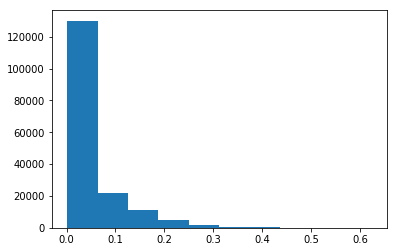

In [25]:
plt.hist(priorizados['score'])
plt.show()

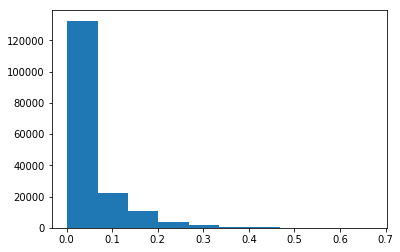

In [26]:
plt.hist(control['score'])
plt.show()

In [ ]:

probs
decil_probs	
0	0.000938
1	0.012560
2	0.024304
3	0.041160
4	0.074228


probs
decil_probs	
0	0.012560
1	0.024303
2	0.041160
3	0.074187
4	0.619235

In [27]:
data_202008['decil'] = np.where(data_202008['score'] <= 0.012560, 1,
                                np.where((data_202008['score'] > 0.012560) & (data_202008['score'] <= 0.024303), 2,
                                        np.where((data_202008['score'] > 0.024303) & (data_202008['score'] <= 0.041160), 3,
                                                np.where((data_202008['score'] > 0.041160) & (data_202008['score'] <= 0.074187), 4, 5))))

In [28]:
priorizados['decil'] = np.where(priorizados['score'] <= 0.012560, 1,
                                np.where((priorizados['score'] > 0.012560) & (priorizados['score'] <= 0.024303), 2,
                                        np.where((priorizados['score'] > 0.024303) & (priorizados['score'] <= 0.041160), 3,
                                                np.where((priorizados['score'] > 0.041160) & (priorizados['score'] <= 0.074187), 4, 5))))

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
control['decil'] = np.where(control['score'] <= 0.012560, 1,
                                np.where((control['score'] > 0.012560) & (control['score'] <= 0.024303), 2,
                                        np.where((control['score'] > 0.024303) & (control['score'] <= 0.041160), 3,
                                                np.where((control['score'] > 0.041160) & (control['score'] <= 0.074187), 4, 5))))

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
print(data_202008['decil'].value_counts())
print(data_202008['decil'].value_counts()/len(data_202008))

1    133470
5     72489
2     62959
3     37372
4     36312
Name: decil, dtype: int64
1    0.389577
5    0.211584
2    0.183767
3    0.109083
4    0.105989
Name: decil, dtype: float64


In [31]:
print(priorizados['decil'].value_counts())
print(priorizados['decil'].value_counts()/len(priorizados))

1    66366
5    36178
2    31596
3    18756
4    18095
Name: decil, dtype: int64
1    0.388126
5    0.211578
2    0.184782
3    0.109690
4    0.105824
Name: decil, dtype: float64


In [32]:
print(control['decil'].value_counts())
print(control['decil'].value_counts()/len(control))

1    67104
5    36311
2    31363
3    18616
4    18217
Name: decil, dtype: int64
1    0.391024
5    0.211589
2    0.182756
3    0.108478
4    0.106153
Name: decil, dtype: float64


In [33]:
vars_final = ['id_cliente','grupo_piloto','score']
base_final = data_202008[vars_final]

In [34]:
base_final.head()

,id_cliente,grupo_piloto,score
0,102652294255605601,priorizado,0.013867
1,102652294440386601,control,0.004212
2,102652294634096501,priorizado,0.024775
3,102652294995745201,priorizado,0.037566
4,102652297090787201,control,0.003476


In [35]:
base_final.grupo_piloto.value_counts()

control       171611
priorizado    170991
Name: grupo_piloto, dtype: int64

In [36]:
base_final.to_parquet("s3://adl-refined-dev-popular/parquet/TC_adquisicion/score_preaprobados_202008",engine='pyarrow', index=False)

In [ ]:
# 	probs
# decil_probs	
# 0	0.000625
# 1	0.012490
# 2	0.024390
# 3	0.041525
# 4	0.074997

In [ ]:
# probs
# decil_probs	
# 0	0.012484
# 1	0.024382
# 2	0.041522
# 3	0.074997
# 4	0.561887

In [ ]:
grupo_piloto

In [38]:
data_202008.score.max()

0.6691697835922241

In [39]:
data_202008.score.min()

0.0012725524138659239

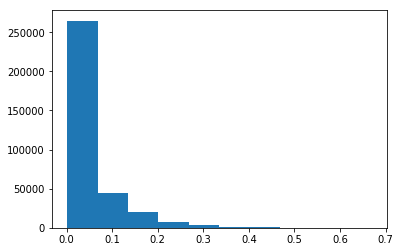

In [40]:
plt.hist(data_202008['score'])
plt.show()